In [1]:
import os
import glob
from parse_corpus import parse_script_lines, parse_script_characters, parse_dialogue, parse_ordered_dialogue
from comparing_strings import getClosestSentiment
import pandas as pd
import matplotlib.pyplot as plt

In [25]:
PATH = 'Brazil_script.html'
chr_lines = parse_dialogue(PATH)
#print(chr_lines)

In [4]:
chr_lines.keys()

dict_keys(['INTERVIEWER', 'HELPMANN', 'JILL', 'MRS. BUTTLE', 'GIRL BUTTLE', 'OFFICIAL', 'CHARLIE', 'BILL', 'MR. KURTZMAN', 'SAM', 'THE FORCES', 'JACK', 'PORTER', 'KURTZMAN', 'DOCTOR', 'MOTHER', "MAITRE'D", 'SPIRO', 'MRS. TERRAIN', 'SHIRLEY', 'PHONE VOICE', 'GENT', 'TUTTLE', 'SPOOR', 'DOWSER', 'NEIGHBOUR', 'GIRL', 'DR. JAFFE', 'VOICE', 'ALISON', 'WARREN', 'LIME', 'TYPIST', 'GUARD', 'GUARD A', 'GUARD B', 'MATTHEWS', 'OFFICIAL A'])

In [5]:
chr_lines['OFFICIAL A']

['Not interested? ', 'Right. Next! ']

In [6]:
chr_lines['JILL'][:5]

[" Who's there? ",
 'Mrs. Buttle, are you alright? ',
 'Who are you? ',
 "There must be some mistake... Mr. Buttle's harmless... ",
 'I want to report a wrongful arrest. ']

In [7]:
corpus = []
for i in chr_lines:
    for j in chr_lines[i]:
        corpus.append(j)
corpus[-2:]

['Not interested? ', 'Right. Next! ']

In [8]:
import re
temp = chr_lines['JILL'][0]#.replace('(*)',"")
temp=re.sub("\(.*?\)","",temp).strip()
temp

"Who's there?"

In [9]:
temp = chr_lines['JILL'][0].replace('(*)',"")
temp

" Who's there? "

In [10]:
doc1 = "Sugar is bad to consume. My sister likes to have sugar, but not my father."
doc2 = "My father spends a lot of time driving my sister around to dance practice."
doc3 = "Doctors suggest that driving may cause increased stress and blood pressure."
doc4 = "Sometimes I feel pressure to perform well at school, but my father never seems to drive my sister to do better."
doc5 = "Health experts say that Sugar is not good for your lifestyle."

# compile documents
doc_complete = [doc1, doc2, doc3, doc4, doc5]



In [11]:
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import numpy as np

stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()


In [12]:
doc_complete = corpus

In [13]:
# Importing Gensim
import gensim
from gensim import corpora


In [14]:
def clean(doc):
    stop = set(stopwords.words('english'))
    exclude = set(string.punctuation)
    lemma = WordNetLemmatizer()
    
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    
    arrayed = [i for i in normalized.split() if len(i) > 2]
    
    return arrayed

def lda_series(series):
    cleaned_series = []
    for i in series:
        cleaned_series.append(np.array(clean(i)))
        
    dictionary = corpora.Dictionary(cleaned_series)
    print('Number of unique tokens: %d' % len(dictionary))
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in cleaned_series]
    
    Lda = gensim.models.ldamodel.LdaModel
    
    lda_model = Lda(doc_term_matrix, num_topics=7, id2word = dictionary, passes=50)
    
    return lda_model, doc_term_matrix, dictionary

In [15]:
modeled, doc_mx, dict = lda_series(doc_complete)

Number of unique tokens: 1426


In [16]:
print(modeled.print_topics(num_topics=7, num_words=10))


[(0, '0.023*"jill" + 0.018*"service" + 0.018*"get" + 0.017*"there" + 0.015*"central" + 0.015*"hello" + 0.014*"got" + 0.014*"jack" + 0.011*"her" + 0.010*"let"'), (1, '0.031*"information" + 0.026*"want" + 0.025*"retrieval" + 0.018*"buttle" + 0.016*"mother" + 0.015*"tuttle" + 0.013*"sam" + 0.012*"sorry" + 0.012*"thats" + 0.011*"alright"'), (2, '0.015*"right" + 0.015*"man" + 0.014*"look" + 0.013*"what" + 0.011*"cant" + 0.011*"thanks" + 0.010*"got" + 0.008*"know" + 0.008*"nothing" + 0.008*"good"'), (3, '0.029*"sam" + 0.027*"lowry" + 0.020*"got" + 0.017*"going" + 0.014*"get" + 0.013*"right" + 0.009*"know" + 0.008*"cheque" + 0.008*"really" + 0.008*"ive"'), (4, '0.056*"you" + 0.019*"know" + 0.015*"sir" + 0.011*"thank" + 0.011*"see" + 0.010*"sam" + 0.009*"much" + 0.008*"like" + 0.007*"could" + 0.007*"anyone"'), (5, '0.033*"well" + 0.026*"yes" + 0.019*"back" + 0.018*"got" + 0.012*"weve" + 0.008*"come" + 0.007*"stop" + 0.007*"bastard" + 0.007*"turn" + 0.007*"sam"'), (6, '0.028*"you" + 0.025*"plea

In [17]:
chrs = []
cols_set = set()
for i in chr_lines:
    temp = clean(''.join(chr_lines[i]))
    dictionary = corpora.Dictionary([temp])
    doc_term_matrix = [dictionary.doc2bow(temp)]
    pt_modeled = modeled[doc_term_matrix]

    topic_n = ['chr_name']
    topic_v = [i]
    for j in pt_modeled[0]:
        cols_set.add(i[0])
        topic_n.append(
            ''.join([wrd[0] +', '  for wrd in modeled.show_topics(formatted=False, num_words= 10)[j[0]][1]]).strip()
        )
        topic_v.append(j[1])
    chrs.append(pd.DataFrame(data = [topic_v], columns = topic_n))
topic_scores = pd.concat(chrs).fillna(0).reset_index(drop = True)

In [18]:
def plot_axis_cluster(clust,cat1, cat2):
    divisor = 3
    
    plt.scatter(clust[cat1], clust[cat2], c = 'red', alpha = 0.6, s=10)
    num1 = clust.columns.get_loc(cat1)
    num2 = clust.columns.get_loc(cat2)
        
    for i, row in clust.iterrows():
        if i % divisor == 0:
            plt.text(row[cat1], row[cat2], row.chr_name)
            
    plt.xlabel(cat1)
    plt.ylabel(cat2)
    
    return plt
    
    

<module 'matplotlib.pyplot' from 'C:\\Users\\zroga\\anaconda3\\envs\\science\\lib\\site-packages\\matplotlib\\pyplot.py'>

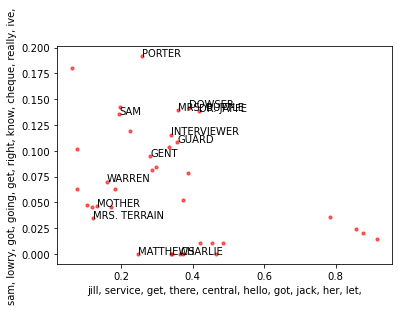

In [19]:
plot_axis_cluster(topic_scores, topic_scores.columns[1], topic_scores.columns[2])

<module 'matplotlib.pyplot' from 'C:\\Users\\zroga\\anaconda3\\envs\\science\\lib\\site-packages\\matplotlib\\pyplot.py'>

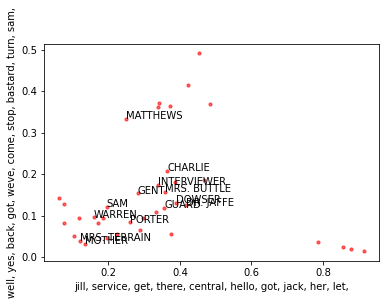

In [20]:
plot_axis_cluster(topic_scores, topic_scores.columns[1], topic_scores.columns[3])

<module 'matplotlib.pyplot' from 'C:\\Users\\zroga\\anaconda3\\envs\\science\\lib\\site-packages\\matplotlib\\pyplot.py'>

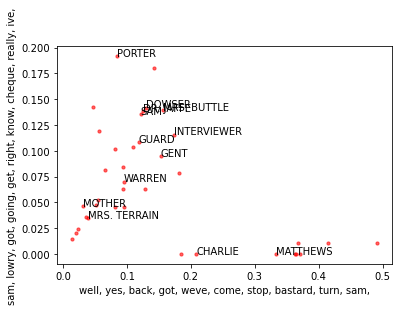

In [21]:
plot_axis_cluster(topic_scores, topic_scores.columns[3], topic_scores.columns[2])

In [22]:
topic_scores.head(2)

,chr_name,"jill, service, get, there, central, hello, got, jack, her, let,","sam, lowry, got, going, get, right, know, cheque, really, ive,","well, yes, back, got, weve, come, stop, bastard, turn, sam,","you, please, here, come, trust, mean, know, there, course, ive,","information, want, retrieval, buttle, mother, tuttle, sam, sorry, thats, alright,","right, man, look, what, cant, thanks, got, know, nothing, good,","you, know, sir, thank, see, sam, much, like, could, anyone,"
0,INTERVIEWER,0.339935,0.115683,0.173605,0.360990,0.00000,0.000000,0.000000
1,HELPMANN,0.075847,0.063338,0.128164,0.111986,0.20393,0.153026,0.263708


In [23]:
topic_scores.describe().T['75%'].min() > 0

True

In [28]:
tops = []
for i, row in topic_scores.describe().T.iloc[0:1].iterrows():
    print([row['75%']])
    #topic_scores[topic_scores[row.index] > 0.35]

[0.3890700787305832]


In [27]:
ordered_lines = parse_ordered_dialogue(PATH)
len(ordered_lines)

828

In [ ]:
doc_complete

In [29]:
chrs = []
cols_set = set()
for i in ordered_lines:
    temp = clean(i)
    dictionary = corpora.Dictionary([temp])
    doc_term_matrix = [dictionary.doc2bow(temp)]
    pt_modeled = modeled[doc_term_matrix]

    topic_n = []#['chr_name']
    topic_v = []#[i]
    for j in pt_modeled[0]:
        cols_set.add(i[0])
        topic_n.append(
            ''.join([wrd[0] +', '  for wrd in modeled.show_topics(formatted=False, num_words= 10)[j[0]][1]]).strip()
        )
        topic_v.append(j[1])
    chrs.append(pd.DataFrame(data = [topic_v], columns = topic_n))
topic_scores = pd.concat(chrs).fillna(0).reset_index(drop = True)

In [43]:
from matplotlib.pyplot import figure
import scipy.interpolate


In [88]:
def get_time_avg(column, window):
    average_y =[]
    for ind in range(len(column) - window + 1):
        average_y.append(np.mean(column[ind:ind+window]))
    return average_y

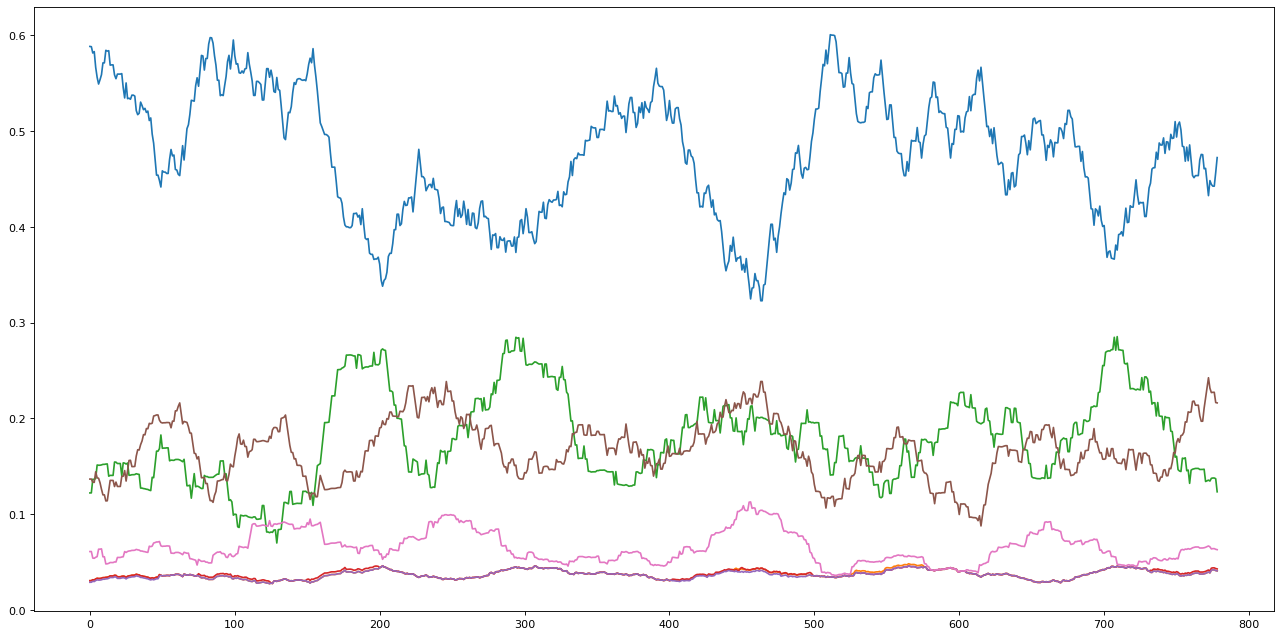

In [90]:
cols = []
for i in range(0, topic_scores.shape[1]):
    temp =  pd.DataFrame(data = get_time_avg(topic_scores.iloc[:, i], 50), columns = [list(topic_scores.columns)[i]])
    cols.append(temp)
df = pd.concat(cols, axis = 1)

figure(figsize=(20, 10), dpi=80)
plt.plot(df)
plt.show()

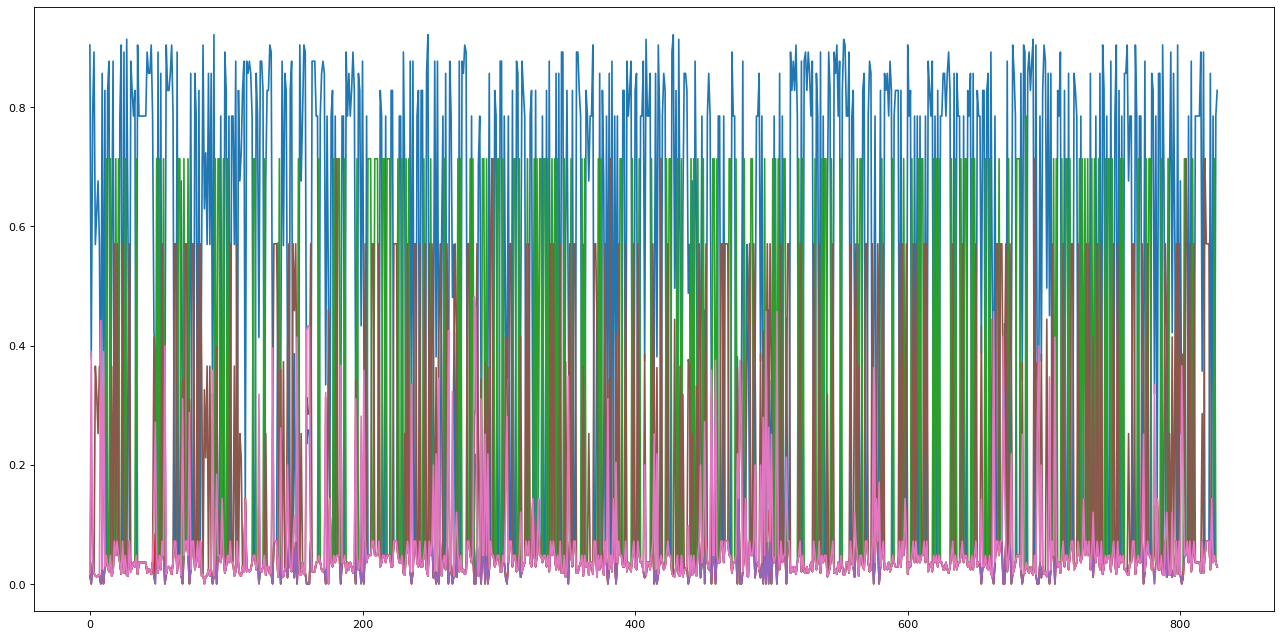

In [91]:
figure(figsize=(20, 10), dpi=80)

plt.plot(topic_scores)

plt.show()